# 개요

* 안드로이드 앱은 핸드폰의 제한된 공간에서 작동 되는데 앱 외부에 있는 리소스(카메라, SMS, 저장공간 등)에 접속하기 위해서 핸드폰 소유자의 접근 허가 권한을 받아야 이용이 가능하다. Permission이란 안드로이드 애플리케이션이 특정 기능을 수행할 수 있는 권한(rights)을 요구하는 것임
* 안드로이드 마쉬멜로우 이전 버전에서는 코드상에 권한허가를 넣어주면 권한 획득이 가능했는데 마쉬멜로우 버전 이후부터는 사용자가 직접 권한을 허락해야 사용이 가능하도록 바뀜
* 안드로이드 6.0 버전부터 사용자 기밀 데이터에 접근할 수 있는 일부 Dangerous permission에 대해서 코드 상에 관련 내용을 서술하고 동적으로 권한을 요청하도록 명시하고 있으나 반드시 AndroidManifest.xml에도 작성해야 함.
* 반드시 AndroidManifest.xml에 선언되므로 정적 분석으로도 충분히 추출 가능

# 추출방법

## aapt 사용

In [11]:
import os, subprocess
terminal = 'aapt d permissions /mnt/c/Users/junve/Desktop/apk/ap.apk > ./result.txt'

# 작성일(23.01.12) 기준 os 라이브러리 방식은 보안상의 단점과, BOF문제가 존재하므로 subprocess 추천
# os 라이브러리
os.system(terminal)

# subprocess 라이브러리
result = subprocess.run(terminal, shell = True)

## androguard 사용

In [15]:
from androguard.misc import AnalyzeAPK
a, *_ = AnalyzeAPK('/home/ghwns82/ap.apk')
a.permissions

['android.permission.ACCESS_NETWORK_STATE',
 'android.permission.WRITE_EXTERNAL_STORAGE',
 'android.permission.INTERNET']

In [17]:
a.get_permissions()

['android.permission.ACCESS_NETWORK_STATE',
 'android.permission.WRITE_EXTERNAL_STORAGE',
 'android.permission.INTERNET']

# Dangerous permission 선정방법

## Deverloper perm-info 웹스크래핑

### permission 정보 추출하기

In [23]:
import re
import csv
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

In [24]:
html_all = requests.get('https://developer.android.com/reference/android/Manifest.permission').text
start = html_all.find('<!-- ========= ENUM CONSTANTS DETAIL ======== -->')
end = html_all.find('<!-- Fields -->')
html = html_all[start:end]

In [25]:
html_list=str(bs(html, 'html.parser')).split('\n')

In [26]:
html_not_blank=''
end_flag=True
for line in html_list:
    line = line.strip()
    if len(line)==0:
        continue
    if end_flag:
        html_not_blank+='\n'+line
    else:
        html_not_blank+=line
    if line[-1] == '>':
        end_flag=True
    else:
        end_flag=False

In [27]:
# 퍼미션의 개수
html_not_blank.count('Constant Value:')

245

In [28]:
# 퍼미션 위치 찾기
index_section_list =[]
start=0
end = 0
for _ in range(html_not_blank.count('Constant Value')):
    end=html_not_blank.find('</', html_not_blank.find('Constant Value:', start))
    index_section_list.append((start,end))
    start = end

### 정보 정리

In [29]:
def find_perm_name(section):
    temp=section.find('Constant Value:')
    start = section.find('\"', temp)
    end = section.find('\"', start+1)
    return section[start+1:end]

In [30]:
def find_added(section):
    if (temp:=section.find('data-version-added'))!=-1:
        start = section.find('\"', temp)
        end = section.find('\"', start+1)
        return section[start+1:end]
    return 0

In [31]:
def find_deprecated(section):
    if (temp:=section.find('data-version-deprecated'))!=-1:
        start = section.find('\"', temp)
        end = section.find('\"', start+1)
        return section[start+1:end]
    return 0

In [32]:
def find_protection_lv(section):
    if (temp:=section.find('<p>Protection level'))!=-1:
        start = section.find(':', temp)
        end = section.find('<',start)
        return section[start+1:end].strip()
    return 0

In [33]:
def find_description(section):
    (end:=section.find('Constant Value:'))!=-1
    start = section.find('<p>')
    if start!=-1 and end !=1:
        return re.sub(r'\<[^>]*\>','', section[start:end]).strip()
    return 0

In [34]:
perms_info=[['name','added','deprecated','protection_lv','details']]
for i,v in enumerate(index_section_list):
    start, end = v
    section = html_not_blank[start:end]
    perms_info.append([find_perm_name(section), find_added(section), find_deprecated(section), find_protection_lv(section), find_description(section)])

In [35]:
with open('./deveolper_permission_list.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(perms_info)

In [36]:
pd.read_csv('./deveolper_permission_list.csv')

,name,added,deprecated,protection_lv,details
0,android.permission.ACCEPT_HANDOVER,28,0,dangerous,Allows a calling app to continue a call which ...
1,android.permission.ACCESS_BACKGROUND_LOCATION,29,0,dangerous,Allows an app to access location in the backgr...
2,android.permission.ACCESS_BLOBS_ACROSS_USERS,31,0,0,Allows an application to access data blobs acr...
3,android.permission.ACCESS_CHECKIN_PROPERTIES,1,0,0,"Allows read/write access to the ""properties"" t..."
4,android.permission.ACCESS_COARSE_LOCATION,1,0,dangerous,Allows an app to access approximate location.A...
...,...,...,...,...,...
240,android.permission.WRITE_GSERVICES,1,0,0,Allows an application to modify the Google ser...
241,android.permission.WRITE_SECURE_SETTINGS,3,0,0,Allows an application to read or write the sec...
242,android.permission.WRITE_SETTINGS,1,0,signature|preinstalled|appop|pre23,Allows an application to read or write the sys...
243,android.permission.WRITE_SYNC_SETTINGS,1,0,normal,Allows applications to write the sync settings...


이제 해당 테이블에서 본인이 필요한 protection lv을 설정하여, 원하는 테이블을 만들면 된다.

## api lv에 따라 벡터 테이블을 만들기

In [44]:
latest_version = 33

In [45]:
table=[['name']+[i for i in range(1, latest_version+1)]]
for i,v in enumerate(perms_info[1:]):
    if v[2]==0:
        deprecated = latest_version+1
    else:
        deprecated = int(v[2])
    if v[1]=='UpsideDownCake':
        added = latest_version
    else:
        added = int(v[1])
    name = v[0]
    vector = [name]+[0]*(added-1) + (deprecated-added) * [1] +[0]*(latest_version-deprecated+1)
    table.append(vector)
    if len(vector) == latest_version+2:
        break

In [46]:
with open('./deveolper_permission_by_api_lv.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(table)

In [47]:
pd.read_csv('./deveolper_permission_by_api_lv.csv')

,name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,android.permission.ACCEPT_HANDOVER,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
1,android.permission.ACCESS_BACKGROUND_LOCATION,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
2,android.permission.ACCESS_BLOBS_ACROSS_USERS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,android.permission.ACCESS_CHECKIN_PROPERTIES,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,android.permission.ACCESS_COARSE_LOCATION,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,android.permission.WRITE_GSERVICES,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
241,android.permission.WRITE_SECURE_SETTINGS,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
242,android.permission.WRITE_SETTINGS,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
243,android.permission.WRITE_SYNC_SETTINGS,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


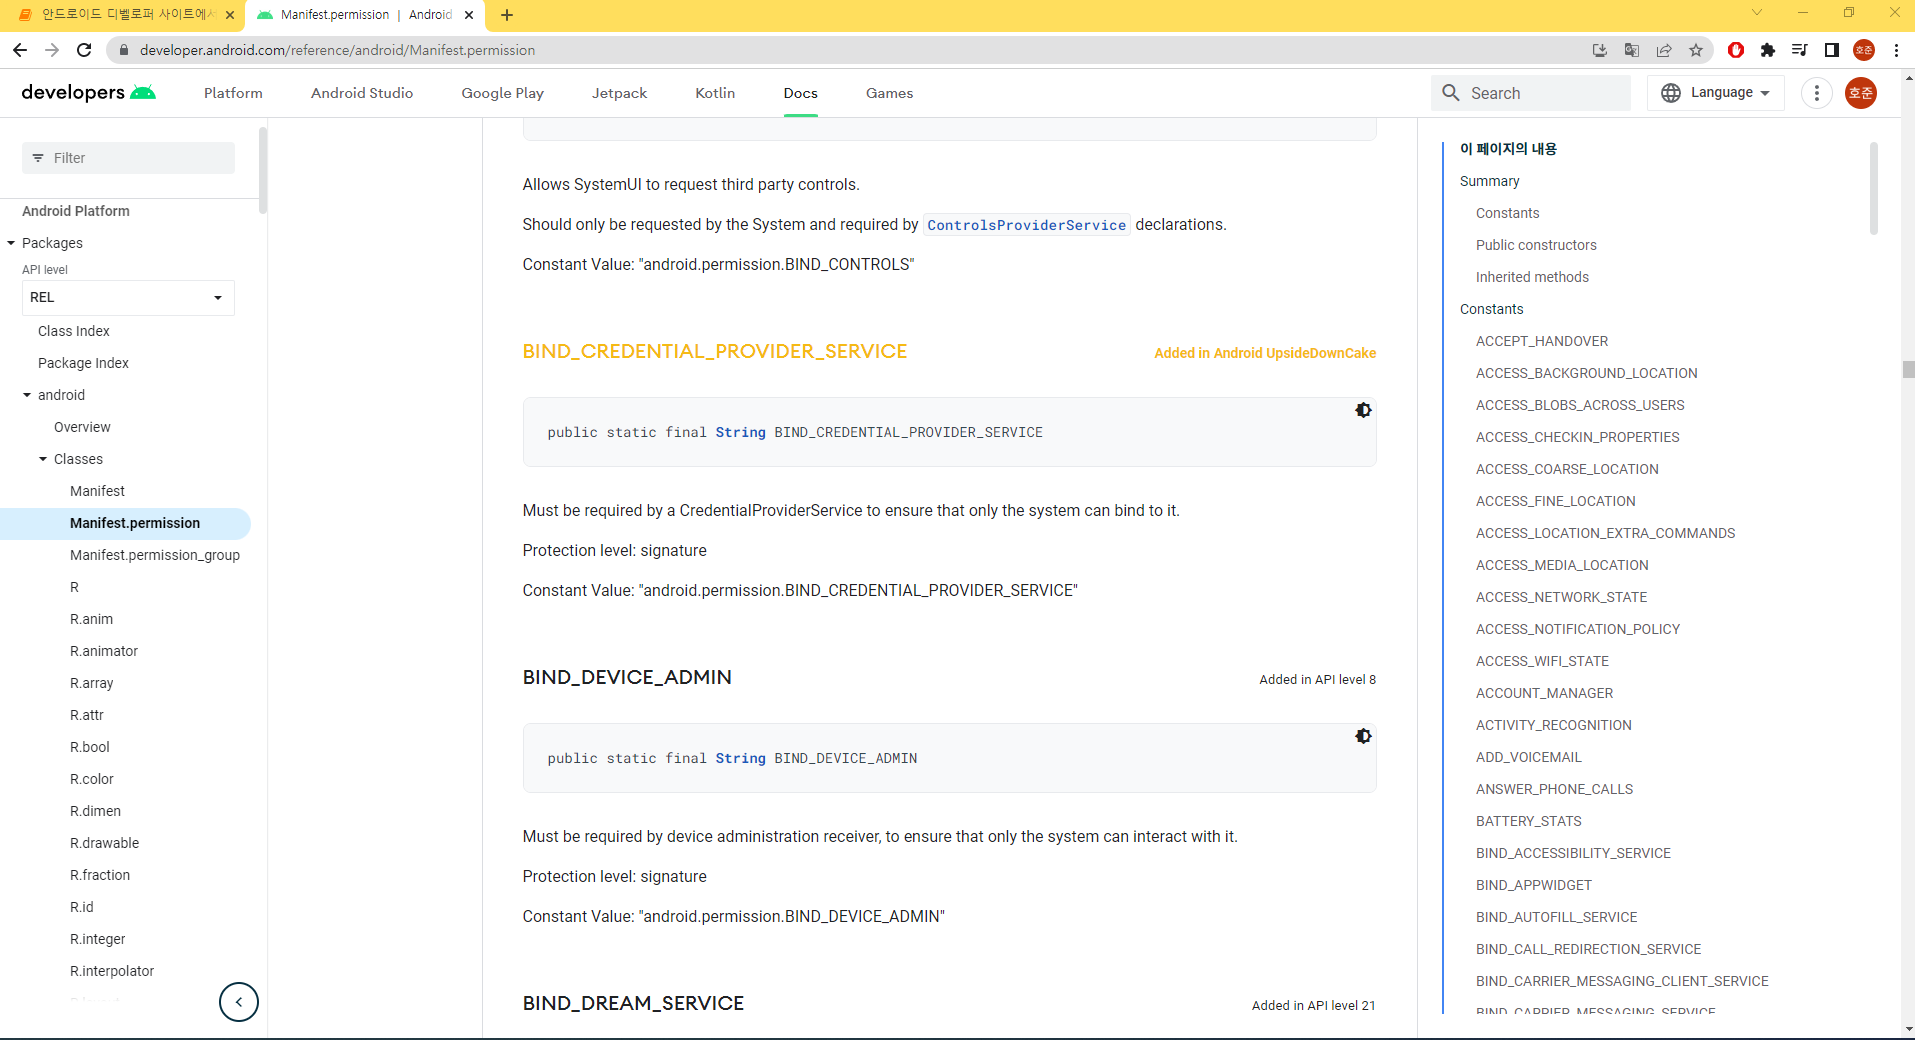